In [88]:
#loading libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import os
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import plot_tree
from sklearn.cluster import KMeans
from scipy.stats import skew, kurtosis
from sklearn.metrics import confusion_matrix
import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.manifold import TSNE

In [100]:
#loading features file
features = pd.read_csv("UCI-HAR Dataset/features.txt",
                       sep="\s+", header=None, names=["index", "feature"])

feature_names = features["feature"].values
def make_unique(names):
    seen = {}
    new_names = []
    for name in names:
        if name not in seen:
            seen[name] = 0
            new_names.append(name)
        else:
            seen[name] += 1
            new_names.append(f"{name}_{seen[name]}")
    return new_names

feature_names = make_unique(feature_names)

In [101]:
#loading training files.
X_train = pd.read_csv("UCI-HAR Dataset/train/X_train.txt",
                      sep="\s+", header=None, names=feature_names)

y_train = pd.read_csv("UCI-HAR Dataset/train/y_train.txt",
                      sep="\s+", header=None, names=["Activity"])

In [102]:
#loading testing files
X_test = pd.read_csv("UCI-HAR Dataset/test/X_test.txt",
                     sep="\s+", header=None, names=feature_names)

y_test = pd.read_csv("UCI-HAR Dataset/test/y_test.txt",
                     sep="\s+", header=None, names=["Activity"])

In [103]:
#loading activities file which is the target file
activity_labels = pd.read_csv("UCI-HAR Dataset/activity_labels.txt",
                              sep="\s+", header=None,
                              names=["id", "activity_name"])

In [104]:
#activity label mapping
activity_map = dict(zip(activity_labels["id"], activity_labels["activity_name"]))

y_train["ActivityName"] = y_train["Activity"].map(activity_map)
y_test["ActivityName"]  = y_test["Activity"].map(activity_map)

In [10]:
X_train.shape

(7352, 561)

In [11]:
y_train.shape

(7352, 2)

In [12]:
X_train.head()

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403         -0.990675         -0.997099         -0.982750   
4         -0.980817         -0.990482         -0.998321         -0.979672   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyroJerkMag-meanFreq()  \
0         -0.923527         -0.934724  ...                        -0.074323   
1         -0.957686         -0.943068  ...                         0.158075   
2         -0.977469         -0.938692  ...                         0.414503   
3         -0.989302         -0.938692  ...                         0.404573   
4         -0.990441         -0.942469  ...                         0.087753   

   fBodyBodyGyroJerkMag-skewness()  fBodyBodyGyroJerkMag-kurtosis()  \
0                        -0.298676                        -0.710304   
1                        -0.595051                        -0.861499   
2                        -0.390748                        -0.760104   
3                        -0.117290                        -0.482845   
4                        -0.351471                        -0.699205   

   angle(tBodyAccMean,gravity)  angle(tBodyAccJerkMean),gravityMean)  \
0                    -0.112754                              0.030400   
1                     0.053477                             -0.007435   
2                    -0.118559                              0.177899   
3                    -0.036788                             -0.012892   
4                     0.123320                              0.122542   

   angle(tBodyGyroMean,gravityMean)  angle(tBodyGyroJerkMean,gravityMean)  \
0                         -0.464761                             -0.018446   
1                         -0.732626                              0.703511   
2                          0.100699                              0.808529   
3                          0.640011                             -0.485366   
4                          0.693578                             -0.615971   

   angle(X,gravityMean)  angle(Y,gravityMean)  angle(Z,gravityMean)  
0             -0.841247              0.179941             -0.058627  
1             -0.844788              0.180289             -0.054317  
2             -0.848933              0.180637             -0.049118  
3             -0.848649              0.181935             -0.047663  
4             -0.847865              0.185151             -0.043892  

[5 rows x 561 columns]

In [13]:
y_train.head()

Activity ActivityName
0         5     STANDING
1         5     STANDING
2         5     STANDING
3         5     STANDING
4         5     STANDING

In [25]:
y_train_Activity = y_train["Activity"].values
y_test_Activity = y_test["Activity"].values

print(y_train_Activity.shape)
print(y_test_Activity.shape)

(7352,)
(2947,)


In [14]:
missing_train=X_train.isnull().sum().sum()
missing_test=X_test.isnull().sum().sum()
missing_train,missing_test

(np.int64(0), np.int64(0))

In [15]:
missing_columns=X_train.isnull().sum()
missing_columns[missing_columns>0]

Series([], dtype: int64)

In [16]:
Q1=X_train.quantile(0.25)
Q3=X_train.quantile(0.75)
IQR=Q3-Q1
outliers = ((X_train < (Q1 - 1.5 * IQR)) | (X_train > (Q3 + 1.5 * IQR))).sum()
outliers[outliers>0]


tBodyAcc-mean()-X                  1795
tBodyAcc-mean()-Y                  1122
tBodyAcc-mean()-Z                  1180
tBodyAcc-std()-X                      2
tBodyAcc-std()-Z                      7
                                   ... 
fBodyBodyGyroJerkMag-kurtosis()     389
angle(tBodyAccMean,gravity)        1065
angle(X,gravityMean)               1437
angle(Y,gravityMean)                776
angle(Z,gravityMean)                705
Length: 500, dtype: int64

In [17]:
below = (X_train < -1).sum().sum()
above = (X_train > 1).sum().sum()

below, above


(np.int64(0), np.int64(0))

In [18]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns=feature_names)

In [20]:
X_train_scaled.describe()

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
count       7.352000e+03       7.352000e+03       7.352000e+03   
mean       -3.131336e-16       4.783986e-17       8.698156e-17   
std         1.000068e+00       1.000068e+00       1.000068e+00   
min        -1.814049e+01      -2.407152e+01      -1.573085e+01   
25%        -1.638693e-01      -1.756427e-01      -2.092798e-01   
50%         3.850502e-02       1.167141e-02       8.206943e-03   
75%         1.988854e-01       1.693906e-01       2.003738e-01   
max         1.032661e+01       2.493878e+01       1.958529e+01   

       tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
count      7.352000e+03       7352.000000      7.352000e+03      7.352000e+03   
mean      -1.507680e-16          0.000000      2.938044e-16      3.865847e-17   
std        1.000068e+00          1.000068      1.000068e+00      1.000068e+00   
min       -8.793362e-01         -0.972792     -9.440787e-01     -8.713436e-01   
25%       -8.631868e-01         -0.929530     -8.968638e-01     -8.562288e-01   
50%       -7.594273e-01         -0.678376     -6.081593e-01     -7.551036e-01   
75%        8.081625e-01          0.948462      8.177048e-01      7.966913e-01   
max        3.577947e+00          2.839526      3.833088e+00      3.845150e+00   

       tBodyAcc-mad()-Y  tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  \
count      7.352000e+03      7.352000e+03      7.352000e+03  ...   
mean      -9.278034e-17      5.412186e-17      1.932924e-17  ...   
std        1.000068e+00      1.000068e+00      1.000068e+00  ...   
min       -9.736247e-01     -9.511122e-01     -9.759168e-01  ...   
25%       -9.286823e-01     -9.034203e-01     -8.587814e-01  ...   
50%       -6.800064e-01     -6.061248e-01     -7.585419e-01  ...   
75%        9.471052e-01      8.222278e-01      8.291412e-01  ...   
max        3.075829e+00      3.878713e+00      2.697113e+00  ...   

       fBodyBodyGyroJerkMag-meanFreq()  fBodyBodyGyroJerkMag-skewness()  \
count                     7.352000e+03                     7.352000e+03   
mean                     -9.664618e-18                     6.571940e-17   
std                       1.000068e+00                     1.000068e+00   
min                      -4.483658e+00                    -2.144460e+00   
25%                      -5.936244e-01                    -7.339585e-01   
50%                       3.468984e-02                    -1.142597e-01   
75%                       6.526596e-01                     5.608611e-01   
max                       3.272840e+00                     4.039226e+00   

       fBodyBodyGyroJerkMag-kurtosis()  angle(tBodyAccMean,gravity)  \
count                     7.352000e+03                 7.352000e+03   
mean                      2.532130e-16                 3.382616e-18   
std                       1.000068e+00                 1.000068e+00   
min                      -1.217541e+00                -2.925683e+00   
25%                      -7.162086e-01                -3.866541e-01   
50%                      -2.809130e-01                 2.451015e-03   
75%                       3.947685e-01                 4.222002e-01   
max                       5.144111e+00                 2.943656e+00   

       angle(tBodyAccJerkMean),gravityMean)  angle(tBodyGyroMean,gravityMean)  \
count                          7.352000e+03                      7.352000e+03   
mean                          -2.319508e-17                     -1.932924e-17   
std                            1.000068e+00                      1.000068e+00   
min                           -2.235646e+00                     -1.658375e+00   
25%                           -6.507937e-01                     -8.072166e-01   
50%                            1.507318e-02                      1.477537e-05   
75%                            6.484291e-01                      8.178415e-01   
max                            2.225893e+00                      1.627550e+00   

       angle(tBodyGyroJ

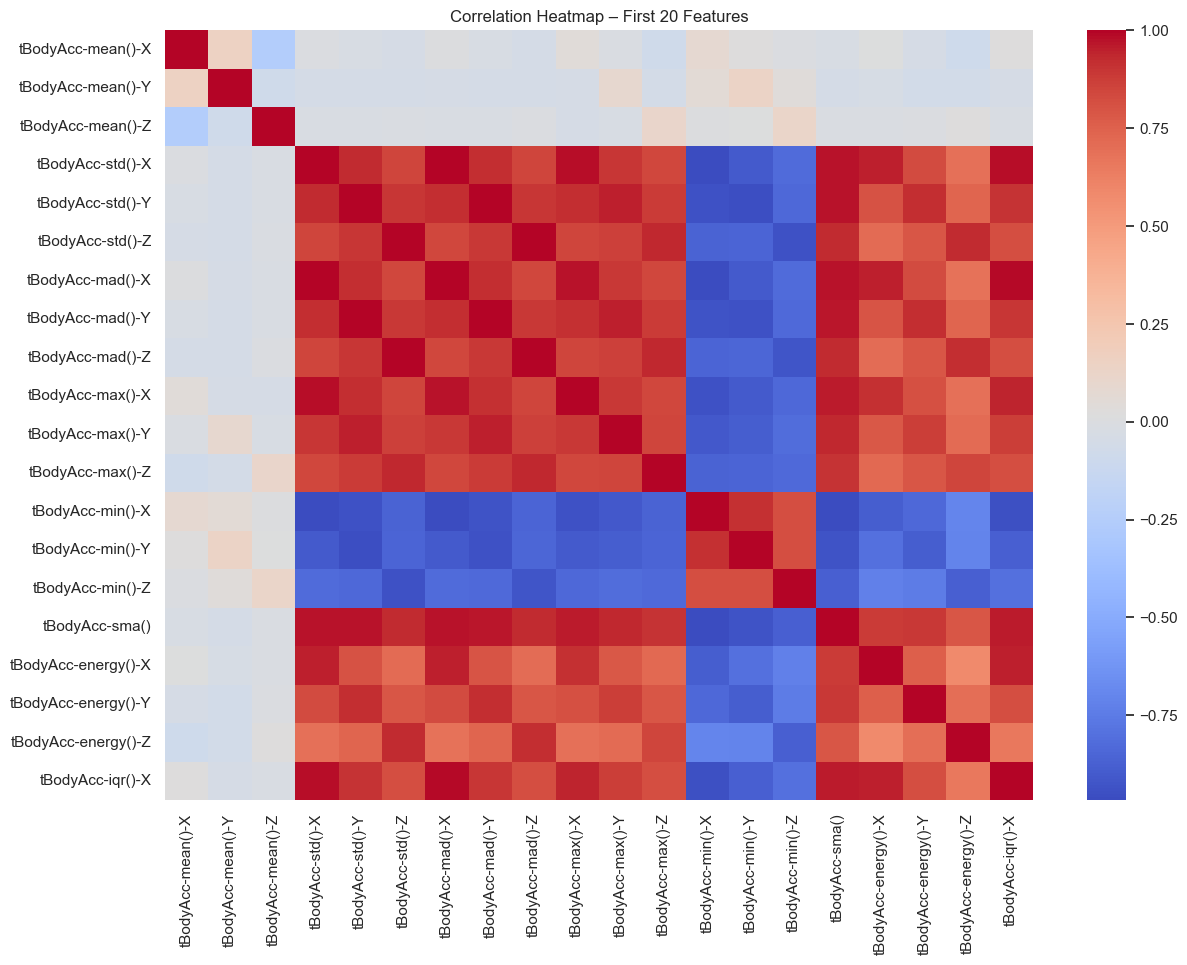

In [105]:
#correlation between first 20 features.
plt.figure(figsize=(14, 10))
corr = X_train_scaled.iloc[:, :20].corr()   
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap – First 20 Features")
plt.savefig("correlation_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

In [107]:
# selecting 15 features using KBest .
selector = SelectKBest(score_func=f_classif, k=15)
X_train_selected = selector.fit_transform(X_train_scaled, y_train_Activity)
X_test_selected = selector.transform(X_test_scaled)
selected_features = selector.get_support(indices=True)
selected_features

array([  9,  40,  49,  52,  56, 102, 103, 104, 234, 271, 287, 366, 367,
       368, 523])

In [27]:
X_selected_df = X_train_scaled.iloc[:, selected_features]

X_selected_df.head()

tBodyAcc-max()-X  tGravityAcc-mean()-X  tGravityAcc-max()-X  \
0         -0.856036              0.579172             0.564447   
1         -0.871359              0.585297             0.564459   
2         -0.863323              0.585910             0.565126   
3         -0.863323              0.587337             0.567903   
4         -0.870260              0.588516             0.567903   

   tGravityAcc-min()-X  tGravityAcc-energy()-X  tBodyAccJerk-entropy()-X  \
0             0.587729                0.663114                 -1.103019   
1             0.601656                0.675094                 -1.187443   
2             0.606080                0.676296                 -1.001490   
3             0.606180                0.679094                 -1.104328   
4             0.607384                0.681407                 -1.150162   

   tBodyAccJerk-entropy()-Y  tBodyAccJerk-entropy()-Z  \
0                 -1.088176                 -1.229514   
1                 -0.872075                 -1.031748   
2                 -0.900188                 -0.998740   
3                 -1.028411                 -1.126010   
4                 -1.014739                 -1.079905   

   tBodyAccJerkMag-entropy()  fBodyAcc-mad()-X  fBodyAcc-entropy()-X  \
0                  -1.085355         -0.873673             -1.014584   
1                  -1.025556         -0.875824             -1.088573   
2                  -0.991118         -0.867676             -1.088573   
3                  -0.987594         -0.868642             -1.088573   
4                  -1.066943         -0.875470             -1.088573   

   fBodyAccJerk-entropy()-X  fBodyAccJerk-entropy()-Y  \
0                 -0.959576                 -0.985386   
1                 -0.959576                 -0.985386   
2                 -0.959576                 -0.985386   
3                 -0.959576                 -0.985386   
4                 -0.959576                 -0.985386   

   fBodyAccJerk-entropy()-Z  fBodyBodyAccJerkMag-entropy()  
0                 -0.976751                      -0.973551  
1                 -0.976751                      -0.973551  
2                 -0.976751                      -0.973551  
3                 -0.976751                      -0.973551  
4                 -0.976751                      -0.973551

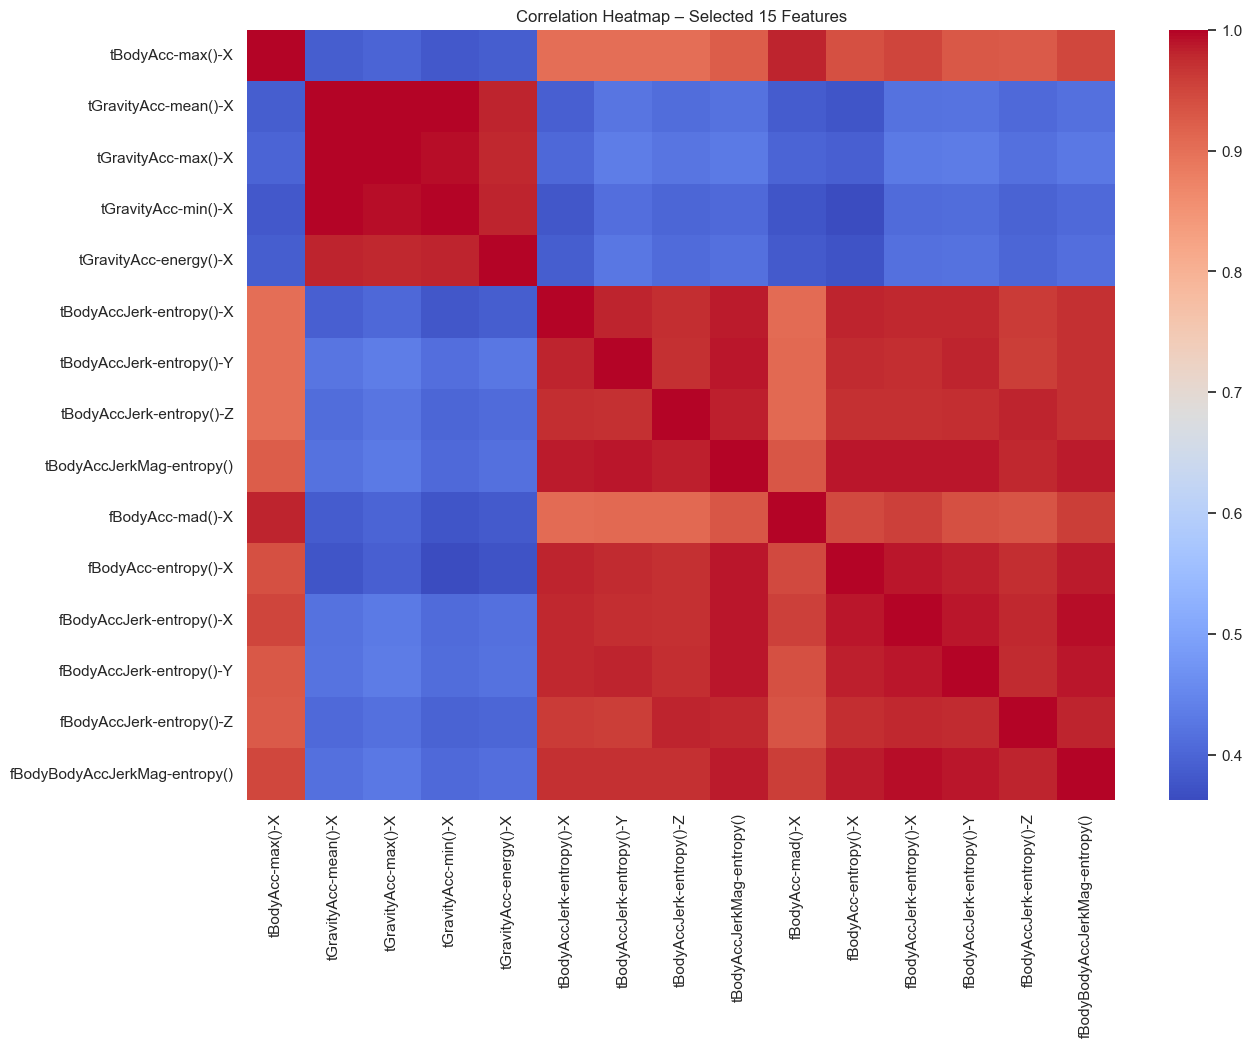

In [108]:
# generating the correlation heatmap
X_selected_df = X_train_scaled.iloc[:, selected_features]
plt.figure(figsize=(14, 10))
corr = X_selected_df.corr()
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap – Selected 15 Features")
plt.savefig("correlation_heatmap_selected_15_features.png", dpi=300, bbox_inches='tight')
plt.show()

In [109]:
#selecting 15 features using PCA
pca = PCA(n_components=15)
pca.fit(X_train_scaled)
loadings = pca.components_
loadings.shape
selected_pca_features = []
for i in range(15):
    feature_idx = np.argmax(np.abs(loadings[i]))
    selected_pca_features.append(feature_idx)
selected_pca_features

[np.int64(280),
 np.int64(295),
 np.int64(56),
 np.int64(51),
 np.int64(558),
 np.int64(552),
 np.int64(452),
 np.int64(32),
 np.int64(458),
 np.int64(191),
 np.int64(499),
 np.int64(31),
 np.int64(467),
 np.int64(35),
 np.int64(120)]

In [40]:
X_train_pca_fs = X_train_scaled.iloc[:, selected_pca_features]
X_test_pca_fs  = X_test_scaled.iloc[:, selected_pca_features]
print(X_train_pca_fs.shape)
print(X_test_pca_fs.shape)

(7352, 15)
(2947, 15)


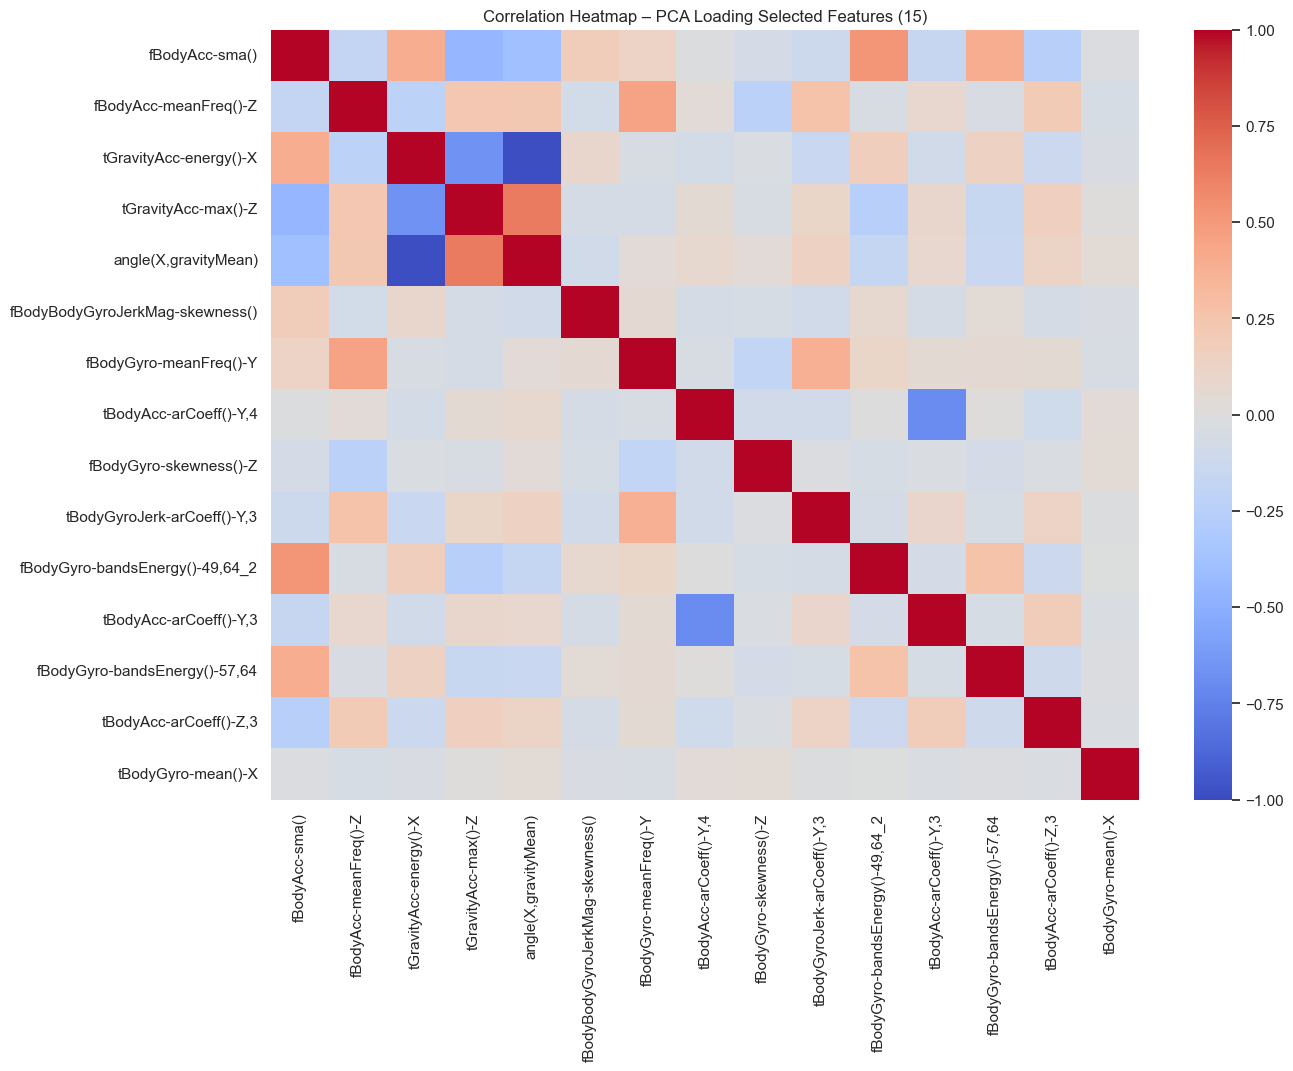

In [110]:
#ploting the correlation heatmap again
plt.figure(figsize=(14, 10))
corr_pca = X_train_pca_fs.corr()
sns.heatmap(corr_pca, annot=False, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap – PCA Loading Selected Features (15)")
plt.savefig("correlation_heatmap_pca_loadings_15.png", dpi=300, bbox_inches='tight')
plt.show()

since we got the correlation heatmap that we wanted we can continue to  ploting the Histogram Distributions of the 15 Selected Features.

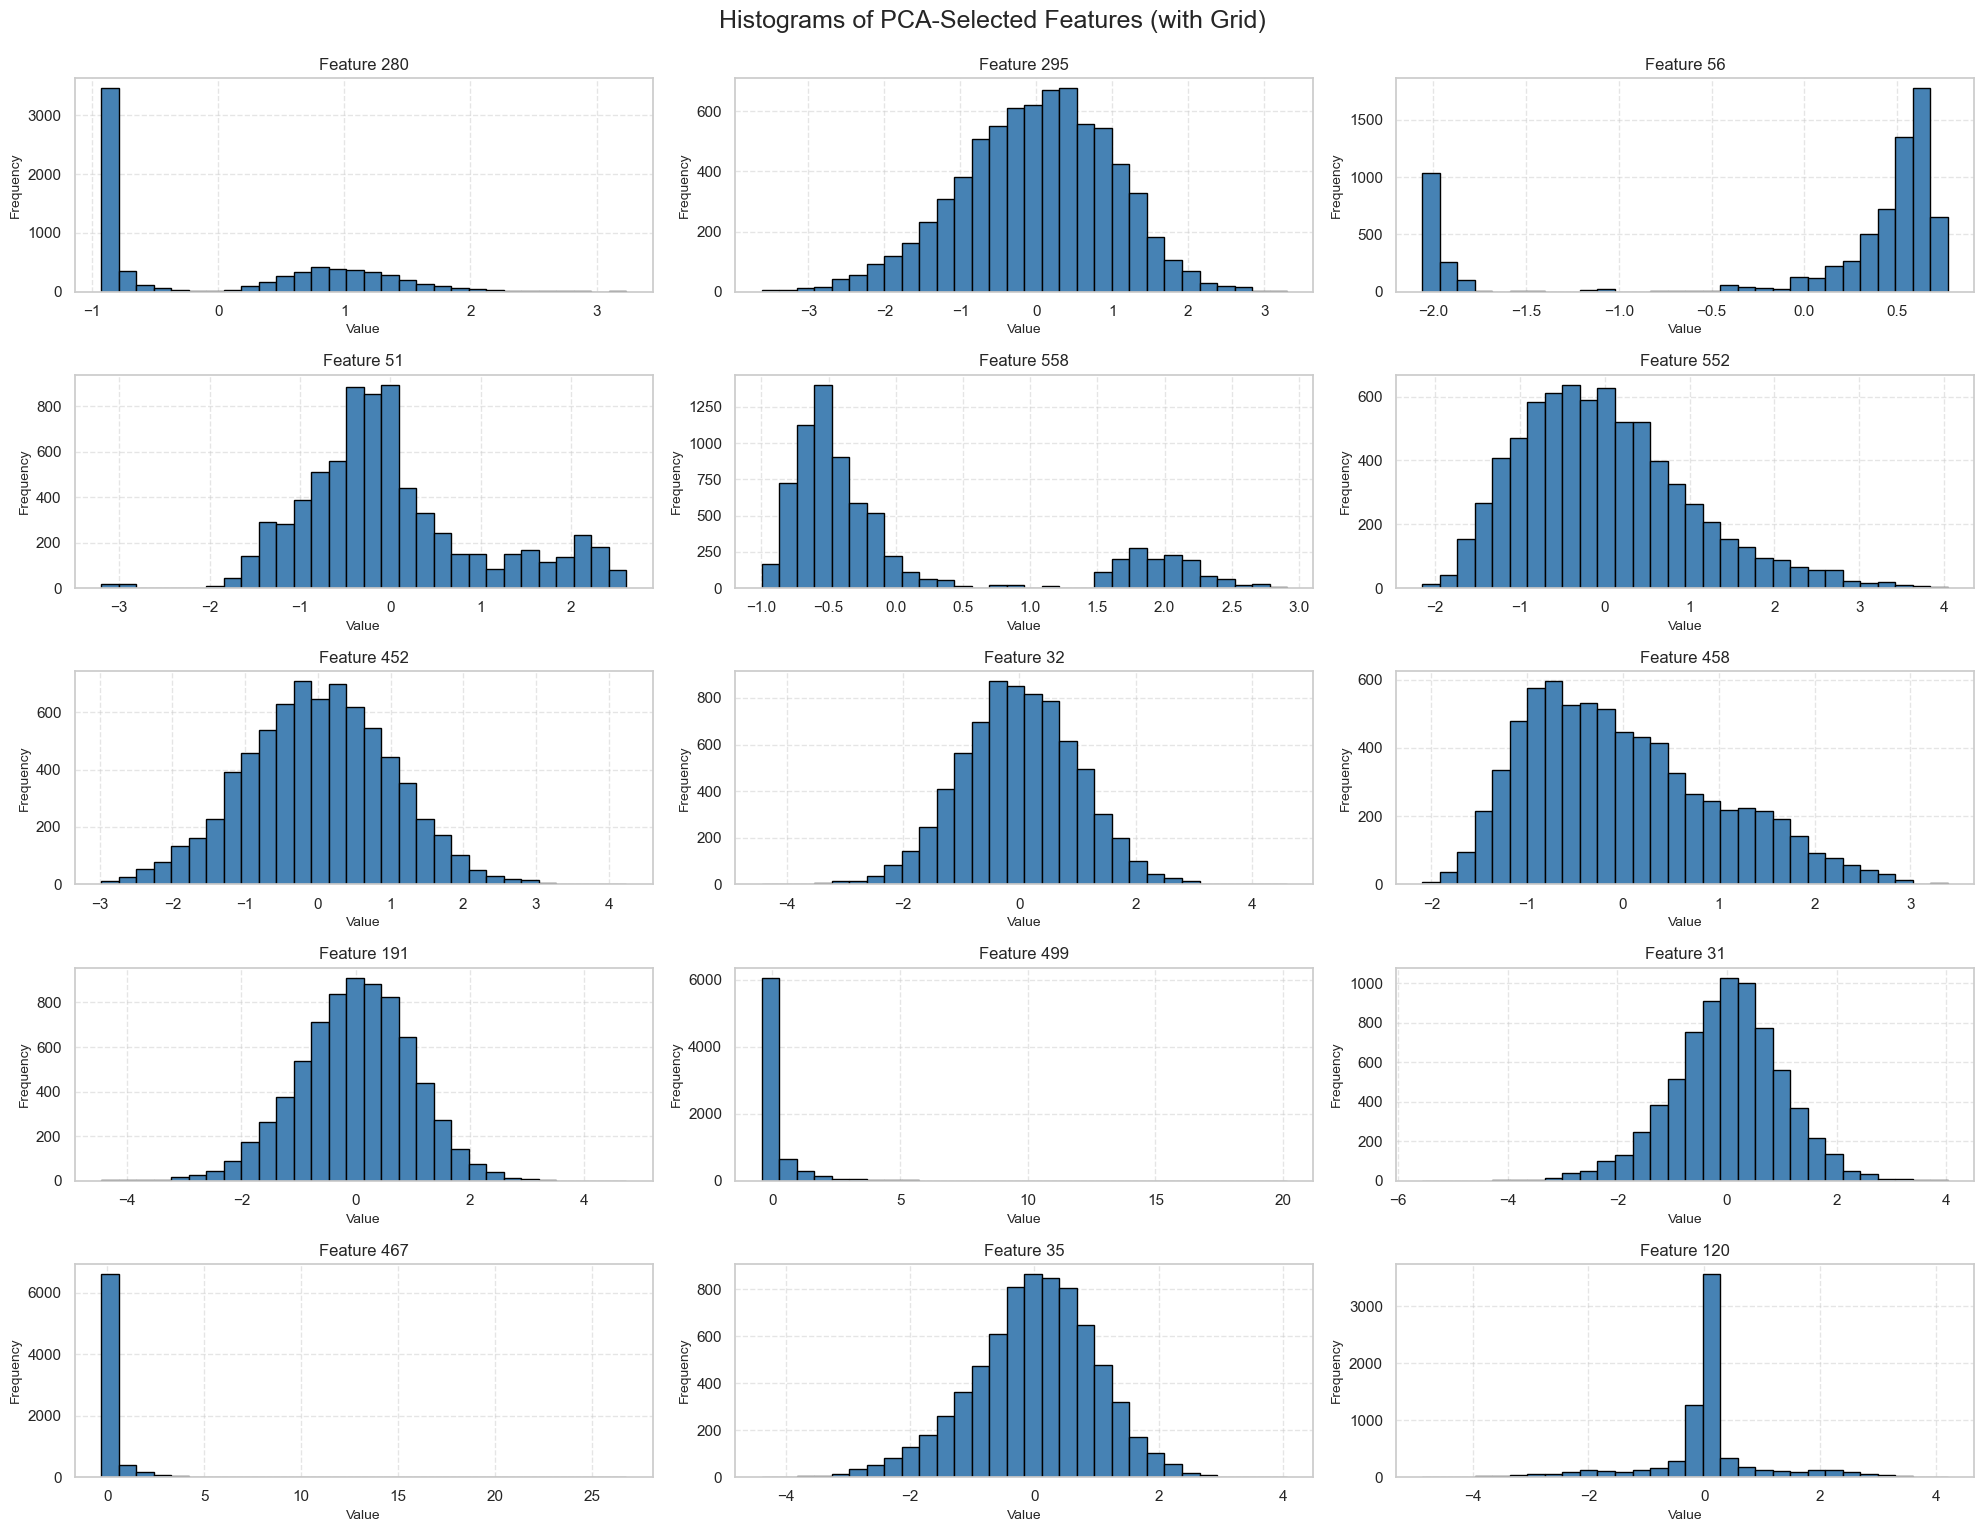

In [111]:
n_features = len(selected_pca_features)
plt.figure(figsize=(20, 15))
for i, idx in enumerate(selected_pca_features):
    plt.subplot(5, 3, i + 1)
    plt.hist(X_train_scaled.iloc[:, idx], bins=30, color='steelblue', edgecolor='black')
    plt.title(f"Feature {idx}", fontsize=12)
    plt.xlabel("Value", fontsize=10)
    plt.ylabel("Frequency", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
plt.suptitle("Histograms of PCA-Selected Features (with Grid)", fontsize=18, y=1.02)
plt.savefig("histograms_pca_selected_features.png", dpi=300, bbox_inches='tight')
plt.show()

In [118]:
features_to_analyze = X_train_pca_fs.columns.tolist()
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((series < lower) | (series > upper)).sum()
summary_data = []
for feature in features_to_analyze:
    values = X_train_pca_fs[feature]
    summary_data.append({
        "Feature": feature,
        "Mean": values.mean(),
        "Std Dev": values.std(),
        "Skewness": skew(values),
        "Kurtosis": kurtosis(values),
        "Outlier Count": count_outliers(values)
    })
summary_df = pd.DataFrame(summary_data)
summary_df

Feature          Mean   Std Dev  Skewness  \
0                    fBodyAcc-sma() -8.504864e-17  1.000068  0.500659   
1             fBodyAcc-meanFreq()-Z -3.865847e-18  1.000068 -0.252438   
2            tGravityAcc-energy()-X  2.319508e-17  1.000068 -1.395575   
3               tGravityAcc-max()-Z  0.000000e+00  1.000068  0.675981   
4              angle(X,gravityMean)  1.005120e-16  1.000068  1.399676   
5   fBodyBodyGyroJerkMag-skewness()  6.571940e-17  1.000068  0.742190   
6            fBodyGyro-meanFreq()-Y  9.278034e-17  1.000068 -0.002502   
7            tBodyAcc-arCoeff()-Y,4 -1.546339e-17  1.000068 -0.013599   
8            fBodyGyro-skewness()-Z  1.159754e-17  1.000068  0.596665   
9       tBodyGyroJerk-arCoeff()-Y,3  3.092678e-17  1.000068 -0.207973   
10  fBodyGyro-bandsEnergy()-49,64_2  1.267998e-15  1.000068  6.484125   
11           tBodyAcc-arCoeff()-Y,3  1.198413e-16  1.000068 -0.190376   
12    fBodyGyro-bandsEnergy()-57,64  5.682796e-16  1.000068  8.454790   
13           tBodyAcc-arCoeff()-Z,3 -5.025602e-17  1.000068 -0.324468   
14               tBodyGyro-mean()-X -2.319508e-17  1.000068 -0.078635   

      Kurtosis  Outlier Count  
0    -1.262199              0  
1    -0.013659             45  
2     0.129850           1461  
3     0.387087            625  
4     0.353441           1437  
5     0.513518            153  
6    -0.071525             41  
7     0.193755             58  
8    -0.298233             38  
9     0.392945             76  
10   71.619974            853  
11    0.665231            140  
12  126.487303           1146  
13    0.359001            106  
14    3.496853           2369

In [112]:
#training the models that we chose.
y_train = y_train_Activity
y_test = y_test_Activity
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42)
}
results = []
for name, model in models.items():
    model.fit(X_train_pca_fs, y_train)
    y_pred = model.predict(X_test_pca_fs)
    y_prob = model.predict_proba(X_test_pca_fs)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    auc = roc_auc_score(y_test, y_prob, average='macro', multi_class='ovr')
    results.append([name, accuracy, precision, recall, f1, auc])
df_results = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1", "AUC"]
)

df_results

Model  Accuracy  Precision    Recall        F1       AUC
0  Decision Tree  0.774007   0.769688  0.769747  0.768574  0.862373
1  Random Forest  0.833051   0.832949  0.828410  0.829877  0.979930
2            SVM  0.806922   0.816001  0.799914  0.800310  0.971177

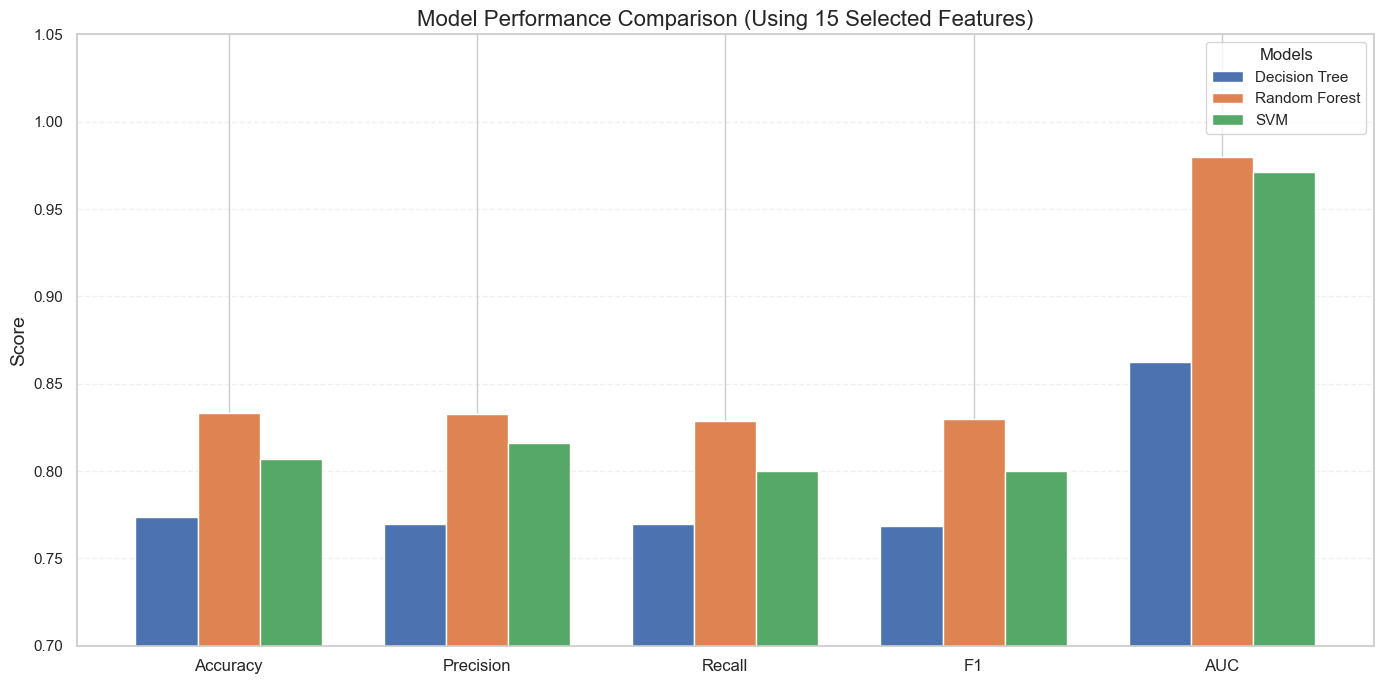

In [113]:
# Updated results from the 15-feature experiment
df_results = pd.DataFrame({
    "Model": ["Decision Tree", "Random Forest", "SVM"],
    "Accuracy":  [0.774007, 0.833051, 0.806922],
    "Precision": [0.769688, 0.832949, 0.816001],
    "Recall":    [0.769747, 0.828410, 0.799914],
    "F1":        [0.768574, 0.829877, 0.800310],
    "AUC":       [0.862373, 0.979930, 0.971177]
})
metrics = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
models = df_results["Model"]
values = df_results[metrics].values
x = np.arange(len(metrics))
width = 0.25  
plt.figure(figsize=(14, 7))
plt.bar(x - width, values[0], width, label='Decision Tree')
plt.bar(x,         values[1], width, label='Random Forest')
plt.bar(x + width, values[2], width, label='SVM')
plt.xticks(x, metrics, fontsize=12)
plt.ylabel("Score", fontsize=14)
plt.title("Model Performance Comparison (Using 15 Selected Features)", fontsize=16)
plt.ylim(0.70, 1.05)
plt.legend(title="Models")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("plots/model_comparison_15_features.png", dpi=300)
plt.show()

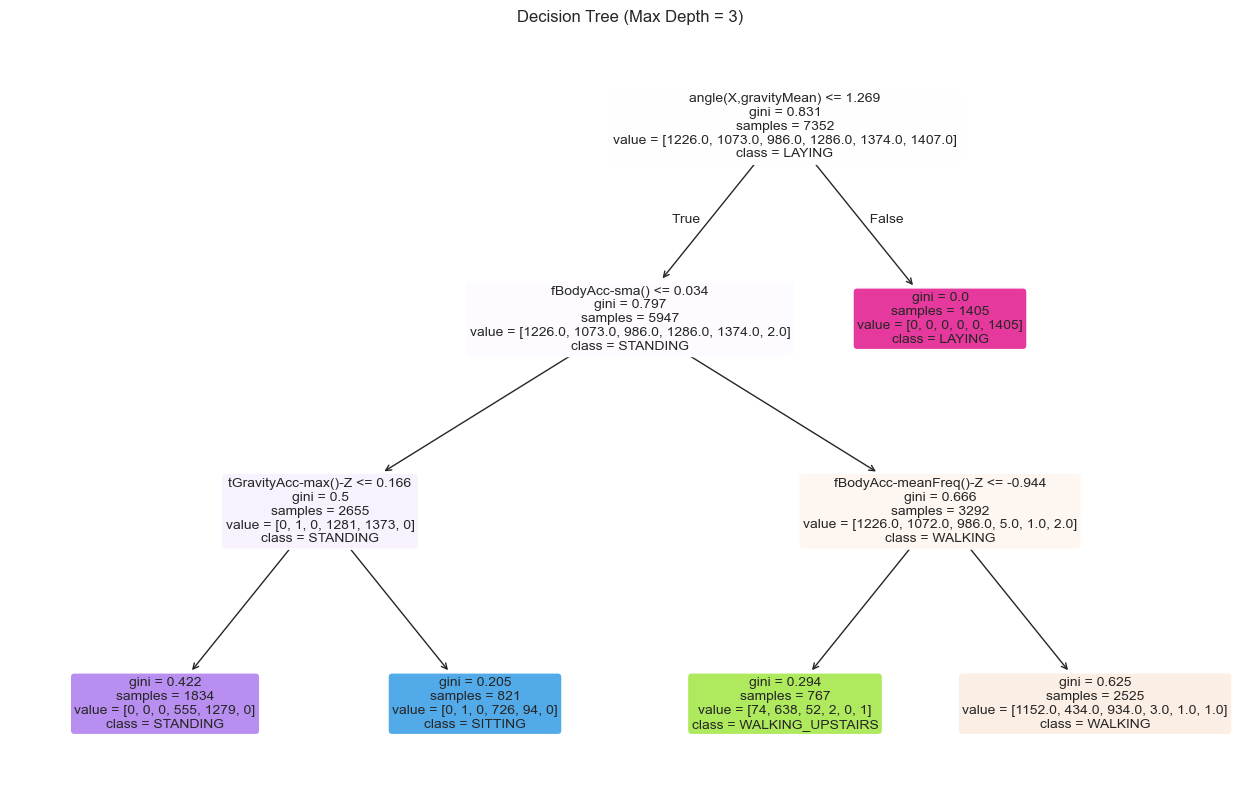

In [114]:
# now lets draw the tree 
dt_small = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_small.fit(X_train_pca_fs, y_train_Activity)
plt.figure(figsize=(16, 10))
plot_tree(
    dt_small,
    feature_names=X_train_pca_fs.columns,
    class_names=["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS",
                 "SITTING", "STANDING", "LAYING"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree (Max Depth = 3)")
plt.savefig("plots/decision_tree_small_depth3.png", dpi=300, bbox_inches='tight')
plt.show()

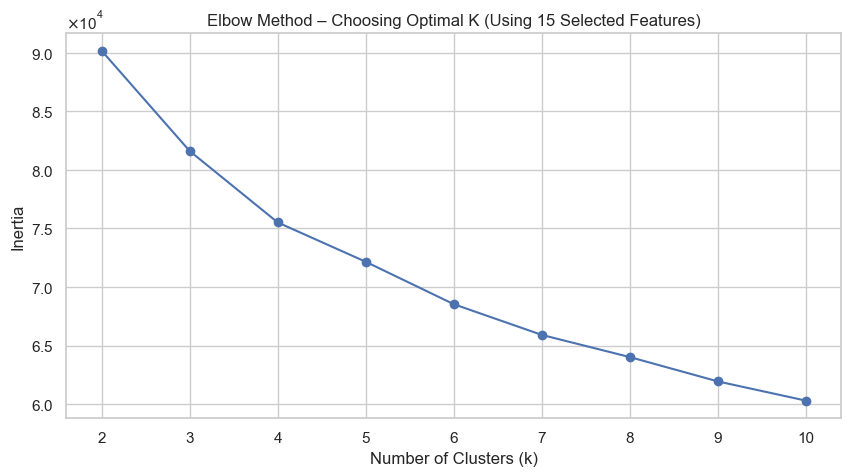

In [115]:
# searching for the best K.
X_train_fs = X_train_pca_fs.values  
inertia = []
K = range(2, 11)  
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_fs)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(10, 5))
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method – Choosing Optimal K (Using 15 Selected Features)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
ax = plt.gca()
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))  
ax.yaxis.set_major_formatter(formatter)
plt.savefig("plots/elbow_method_kmeans_15_features.png", dpi=300, bbox_inches='tight')
plt.show()

as we can see from the last plot the optimal k is 4 so we will continue using it

In [116]:
optimal_k = 4
X_train_fs = X_train_pca_fs.values
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_train_fs)
cluster_labels[:20] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
      dtype=int32)

In [117]:
clusters_df = pd.DataFrame(X_train_fs, columns=X_train_pca_fs.columns)
clusters_df["Cluster"] = cluster_labels
cluster_summary = clusters_df.groupby("Cluster").mean()
cluster_summary_transposed = cluster_summary.T
cluster_summary_transposed

Cluster                                 0         1         2         3
fBodyAcc-sma()                  -0.802319  0.280061  1.246551 -0.839016
fBodyAcc-meanFreq()-Z            0.401428 -0.964548  0.171536  0.512651
tGravityAcc-energy()-X           0.506421  0.432348  0.506923 -1.949715
tGravityAcc-max()-Z             -0.132084 -0.410778 -0.533840  1.425083
angle(X,gravityMean)            -0.504690 -0.413400 -0.502324  1.915819
fBodyBodyGyroJerkMag-skewness() -0.340326  0.085546  0.411993 -0.161424
fBodyGyro-meanFreq()-Y           0.147194 -0.769811  0.577977  0.089181
tBodyAcc-arCoeff()-Y,4          -0.225521  0.300400 -0.165747  0.126570
fBodyGyro-skewness()-Z          -0.057955  0.383923 -0.325743 -0.018314
tBodyGyroJerk-arCoeff()-Y,3      0.284279 -0.629948  0.102516  0.315705
fBodyGyro-bandsEnergy()-49,64_2 -0.398750 -0.077736  0.833827 -0.399027
tBodyAcc-arCoeff()-Y,3           0.314750 -0.437735 -0.044181  0.201308
fBodyGyro-bandsEnergy()-57,64   -0.317583 -0.015832  0.606895 -0.306650
tBodyAcc-arCoeff()-Z,3           0.361860 -0.462103 -0.149729  0.302718
tBodyGyro-mean()-X              -0.009373  0.326620 -0.376727  0.055511

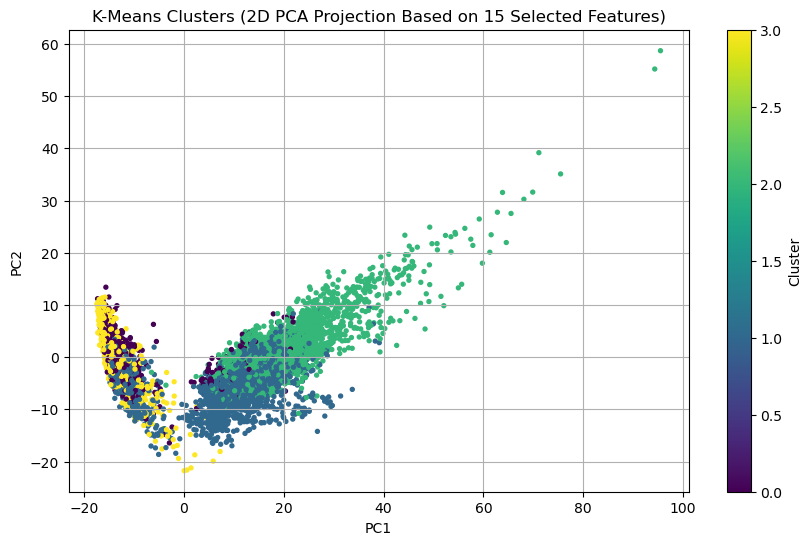

In [59]:
pca_2d = PCA(n_components=2)
X_train_2d = pca_2d.fit_transform(X_train_scaled)
plt.figure(figsize=(10, 6))
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], 
            c=cluster_labels, cmap='viridis', s=8)
plt.title("K-Means Clusters (2D PCA Projection Based on 15 Selected Features)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()

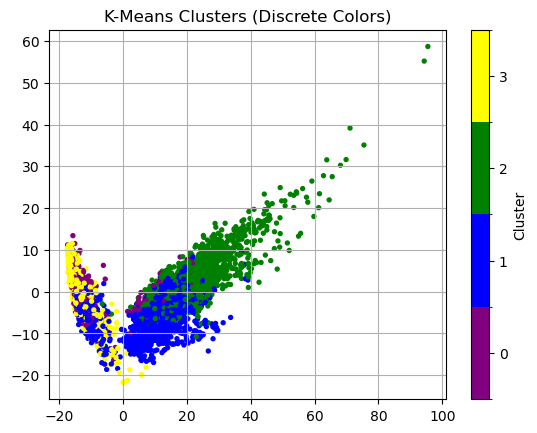

In [79]:
colors = ['purple', 'blue', 'green', 'yellow']
cmap = ListedColormap(colors)
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm = BoundaryNorm(bounds, cmap.N)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], 
            c=cluster_labels, cmap=cmap, norm=norm, s=8)
plt.colorbar(ticks=[0,1,2,3], label="Cluster")
plt.title("K-Means Clusters (Discrete Colors)")
plt.grid(True)
plt.show()

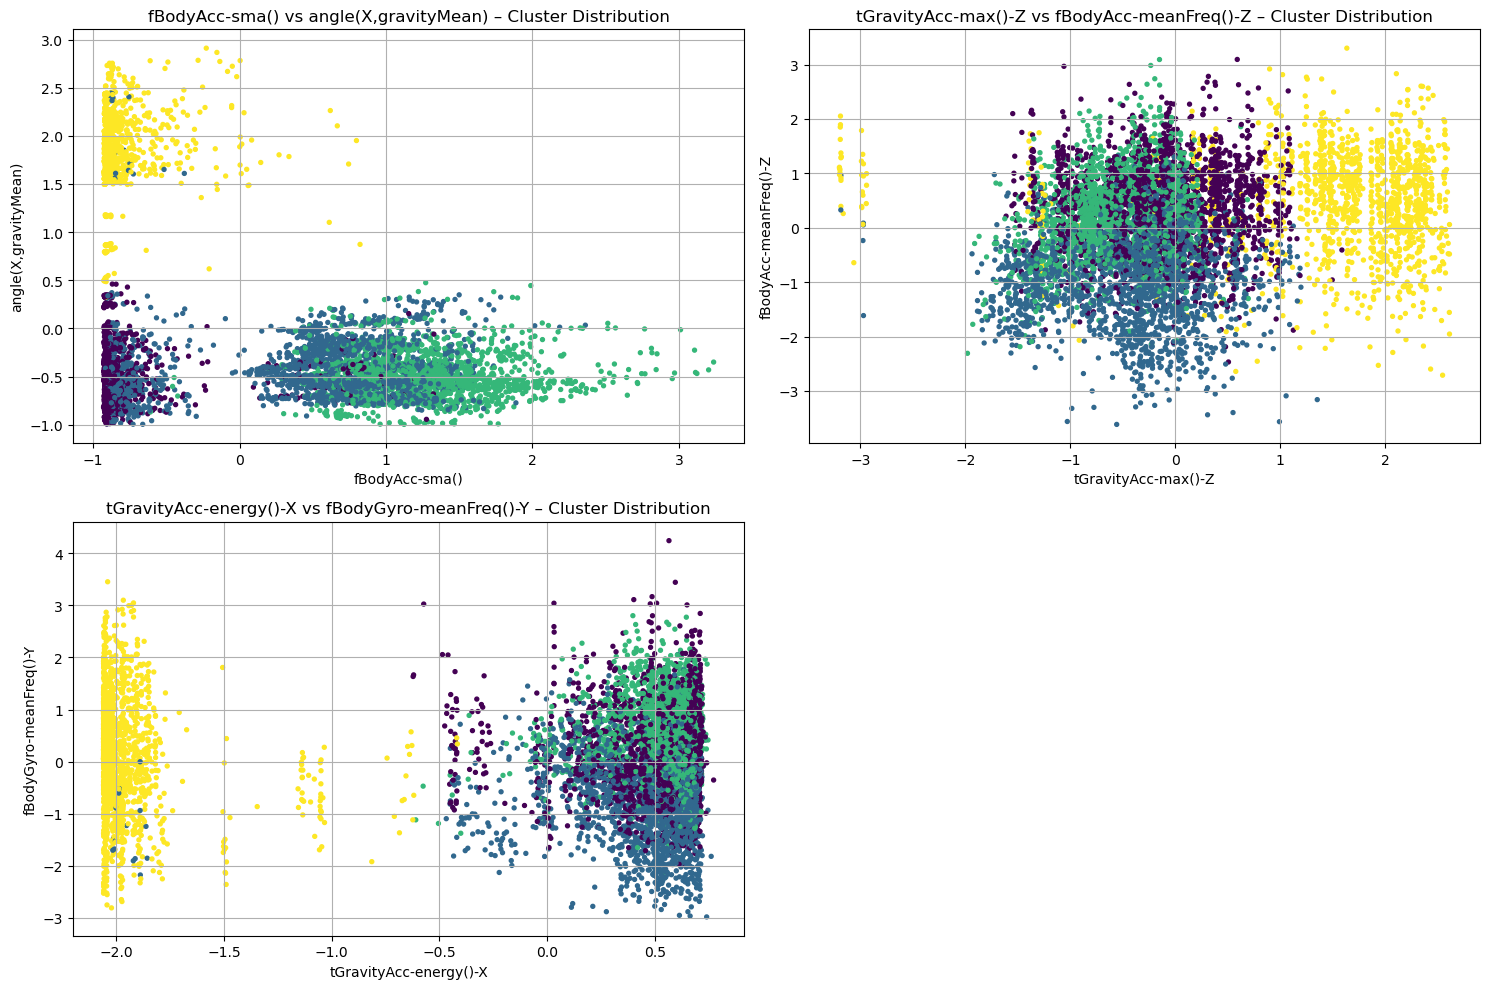

In [80]:
feature_pairs = [
    ("fBodyAcc-sma()", "angle(X,gravityMean)"),
    ("tGravityAcc-max()-Z", "fBodyAcc-meanFreq()-Z"),
    ("tGravityAcc-energy()-X", "fBodyGyro-meanFreq()-Y")
]
plt.figure(figsize=(15, 10))
for i, (feat_x, feat_y) in enumerate(feature_pairs):
    plt.subplot(2, 2, i + 1)
    plt.scatter(
        X_train_fs[:, X_train_pca_fs.columns.get_loc(feat_x)],
        X_train_fs[:, X_train_pca_fs.columns.get_loc(feat_y)],
        c=cluster_labels, cmap='viridis', s=8
    )
    plt.xlabel(feat_x)
    plt.ylabel(feat_y)
    plt.title(f"{feat_x} vs {feat_y} – Cluster Distribution")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [60]:
ct = pd.crosstab(cluster_labels,
                 y_train,
                 rownames=["Cluster"],
                 colnames=["True Label"])
ct

True Label    1    2    3    4     5     6
Cluster                                   
0            74   12   16  943  1018     0
1           367  798  155  276   353    16
2           785  263  815    1     3     0
3             0    0    0   66     0  1391

In [61]:
label_mapping = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}

# Convert to DataFrame for display
activity_table = pd.DataFrame(list(label_mapping.items()), columns=["Label", "Activity"])

activity_table

Label            Activity
0      1             WALKING
1      2    WALKING_UPSTAIRS
2      3  WALKING_DOWNSTAIRS
3      4             SITTING
4      5            STANDING
5      6              LAYING

In [65]:
# Using cluster_summary generated from the 15 selected features
df_centroids = cluster_summary.copy()
top_features_per_cluster = {}
for cluster in df_centroids.index:
    current = df_centroids.loc[cluster]            # centroid of this cluster
    others = df_centroids.drop(cluster).mean()     # average of all other clusters
    diff = (current - others).abs().sort_values(ascending=False)
    top_features_per_cluster[cluster] = diff.head(10)
for cluster, features in top_features_per_cluster.items():
    print(f"\nCluster {cluster} – Top distinguishing features:\n")
    print(features)


Cluster 0 – Top distinguishing features:

fBodyAcc-sma()                     1.031517
tGravityAcc-energy()-X             0.843236
angle(X,gravityMean)               0.838055
fBodyGyro-bandsEnergy()-49,64_2    0.517771
fBodyAcc-meanFreq()-Z              0.494882
tBodyAcc-arCoeff()-Z,3             0.464898
fBodyBodyGyroJerkMag-skewness()    0.452364
fBodyGyro-bandsEnergy()-57,64      0.412388
tBodyAcc-arCoeff()-Y,3             0.408286
tBodyGyroJerk-arCoeff()-Y,3        0.354854
dtype: float64

Cluster 1 – Top distinguishing features:

fBodyAcc-meanFreq()-Z          1.326419
fBodyGyro-meanFreq()-Y         1.041261
tBodyGyroJerk-arCoeff()-Y,3    0.864115
tGravityAcc-energy()-X         0.744471
angle(X,gravityMean)           0.716335
tGravityAcc-max()-Z            0.663831
tBodyAcc-arCoeff()-Z,3         0.633719
tBodyAcc-arCoeff()-Y,3         0.595028
fBodyGyro-skewness()-Z         0.517927
tBodyGyro-mean()-X             0.436816
dtype: float64

Cluster 2 – Top distinguishing features:

f

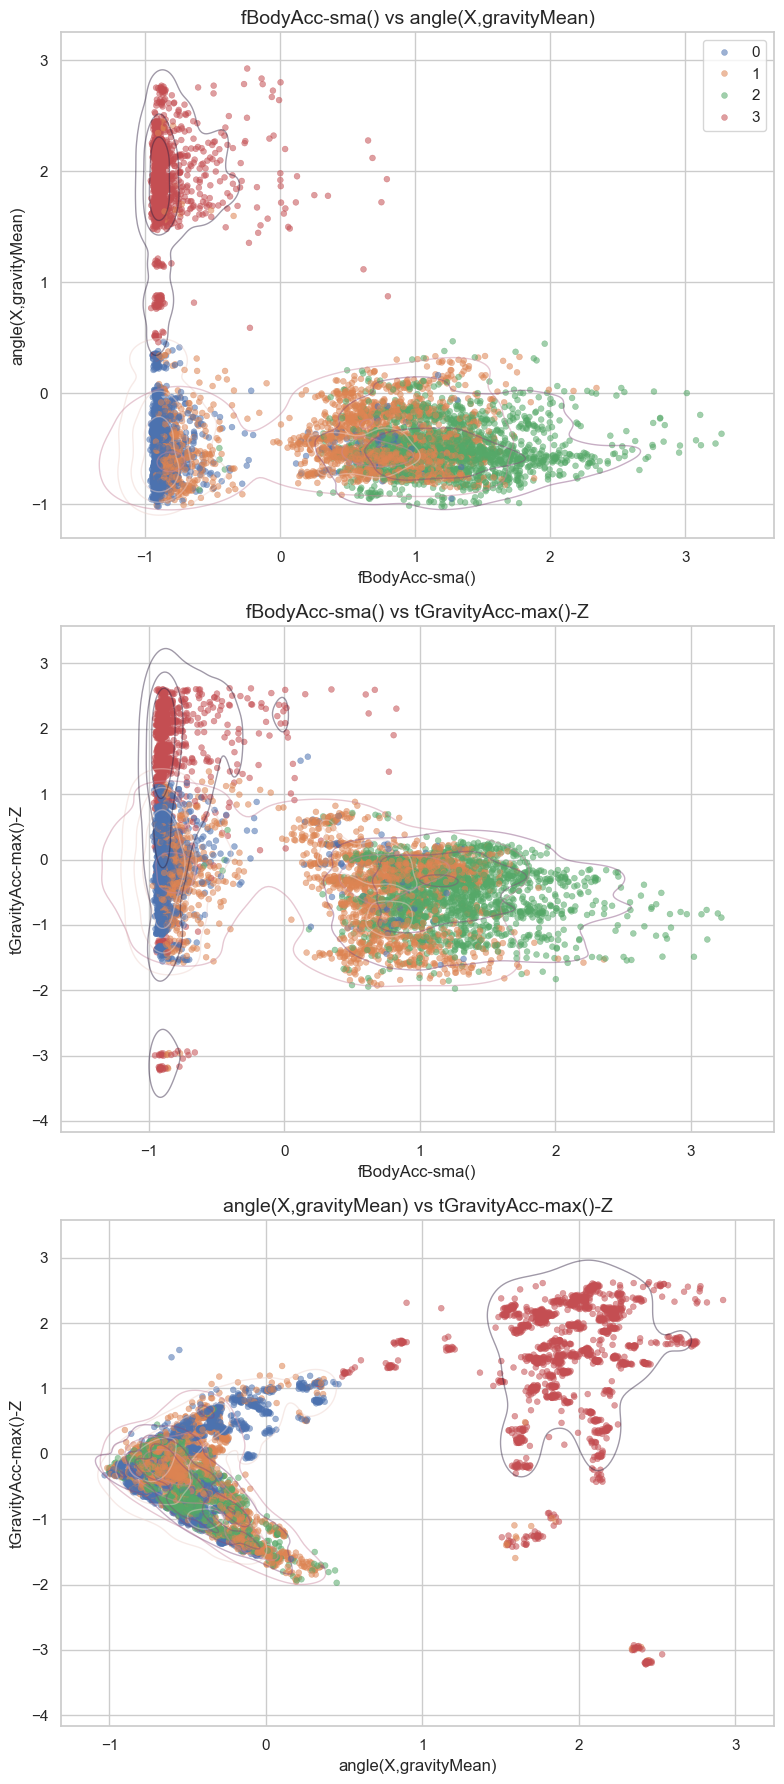

In [119]:
sns.set(style="whitegrid")
feat1 = "fBodyAcc-sma()"
feat2 = "angle(X,gravityMean)"
feat3 = "tGravityAcc-max()-Z"
pairs = [
    (feat1, feat2),
    (feat1, feat3),
    (feat2, feat3)
]
titles = [
    f"{feat1} vs {feat2}",
    f"{feat1} vs {feat3}",
    f"{feat2} vs {feat3}"
]
plt.figure(figsize=(8, 18))
for i, ((x_f, y_f), title) in enumerate(zip(pairs, titles), start=1):
    plt.subplot(3, 1, i)
    jitter_x = df_clusters[x_f] + np.random.normal(0, 0.015, len(df_clusters))
    jitter_y = df_clusters[y_f] + np.random.normal(0, 0.015, len(df_clusters))
    sns.scatterplot(
        x=jitter_x,
        y=jitter_y,
        hue=df_clusters["Cluster"],
        palette="deep",
        alpha=0.55,
        s=18,
        edgecolor=None
    )
    sns.kdeplot(
        x=jitter_x,
        y=jitter_y,
        hue=df_clusters["Cluster"],
        levels=4,
        alpha=0.45,
        linewidths=1
    )
    plt.title(title, fontsize=14)
    plt.xlabel(x_f, fontsize=12)
    plt.ylabel(y_f, fontsize=12)
    if i == 1:
        plt.legend()
    else:
        plt.legend([],[], frameon=False)
    plt.savefig(f"cluster_plot_{i}.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

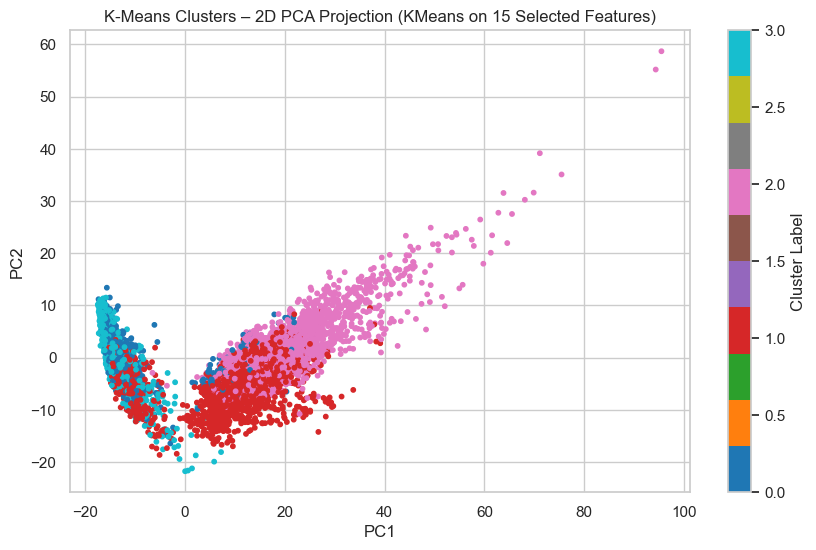

Saved: plots/pca_clusters_15_features.png


In [120]:
# PCA to 2D (for visualization only)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)  
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                      c=cluster_labels, cmap="tab10", s=10)
plt.title("K-Means Clusters – 2D PCA Projection (KMeans on 15 Selected Features)")
plt.xlabel("PC1")
plt.ylabel("PC2")
cbar = plt.colorbar(scatter)
cbar.set_label("Cluster Label")
plt.grid(True)
plt.savefig("plots/pca_clusters_15_features.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved: plots/pca_clusters_15_features.png")

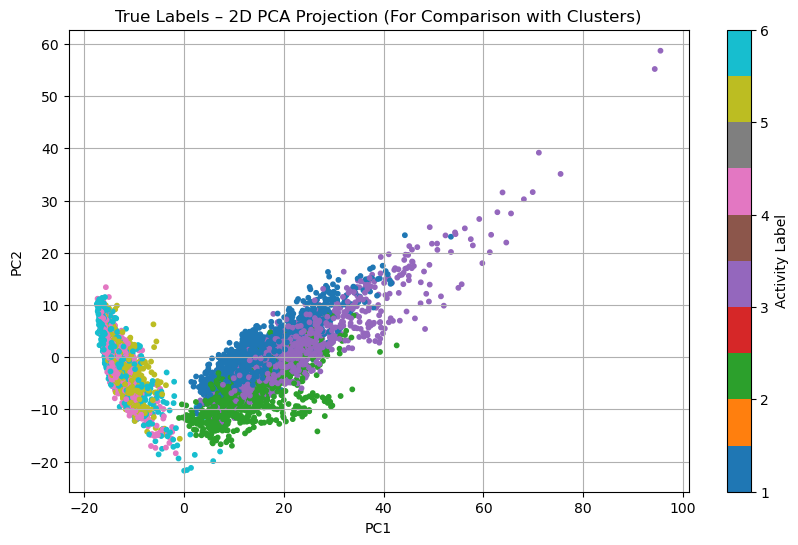

Saved: plots/pca_true_labels_15_features.png


In [68]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                      c=y_train, cmap="tab10", s=10)   
plt.title("True Labels – 2D PCA Projection (For Comparison with Clusters)")
plt.xlabel("PC1")
plt.ylabel("PC2")
cbar = plt.colorbar(scatter)
cbar.set_label("Activity Label")
plt.grid(True)
plt.savefig("plots/pca_true_labels_15_features.png",
            dpi=300, bbox_inches="tight")
plt.show()
print("Saved: plots/pca_true_labels_15_features.png")

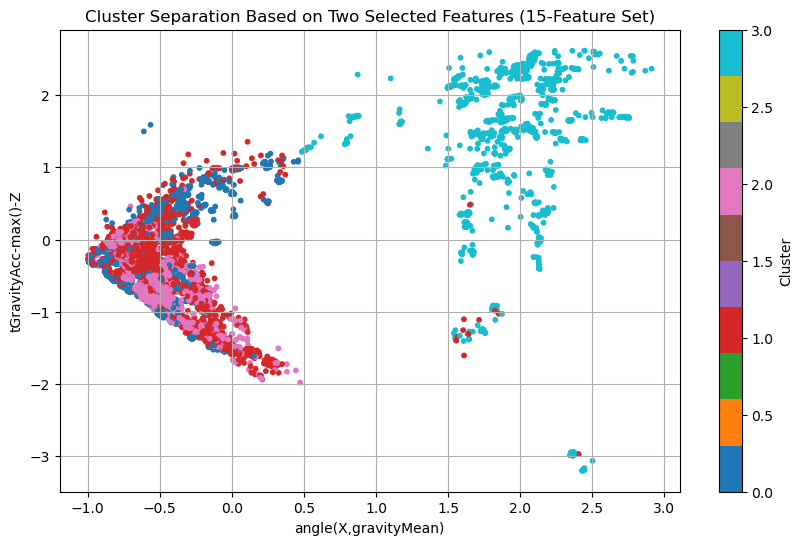

Saved: plots/feature_scatter_15_features.png


In [72]:
feat_y = "tGravityAcc-max()-Z"
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_train_pca_fs[feat_x],
    X_train_pca_fs[feat_y],
    c=cluster_labels,
    cmap="tab10",
    s=10
)
plt.title("Cluster Separation Based on Two Selected Features (15-Feature Set)")
plt.xlabel(feat_x)
plt.ylabel(feat_y)
cbar = plt.colorbar(scatter)
cbar.set_label("Cluster")
plt.grid(True)
plt.savefig("plots/feature_scatter_15_features.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved: plots/feature_scatter_15_features.png")

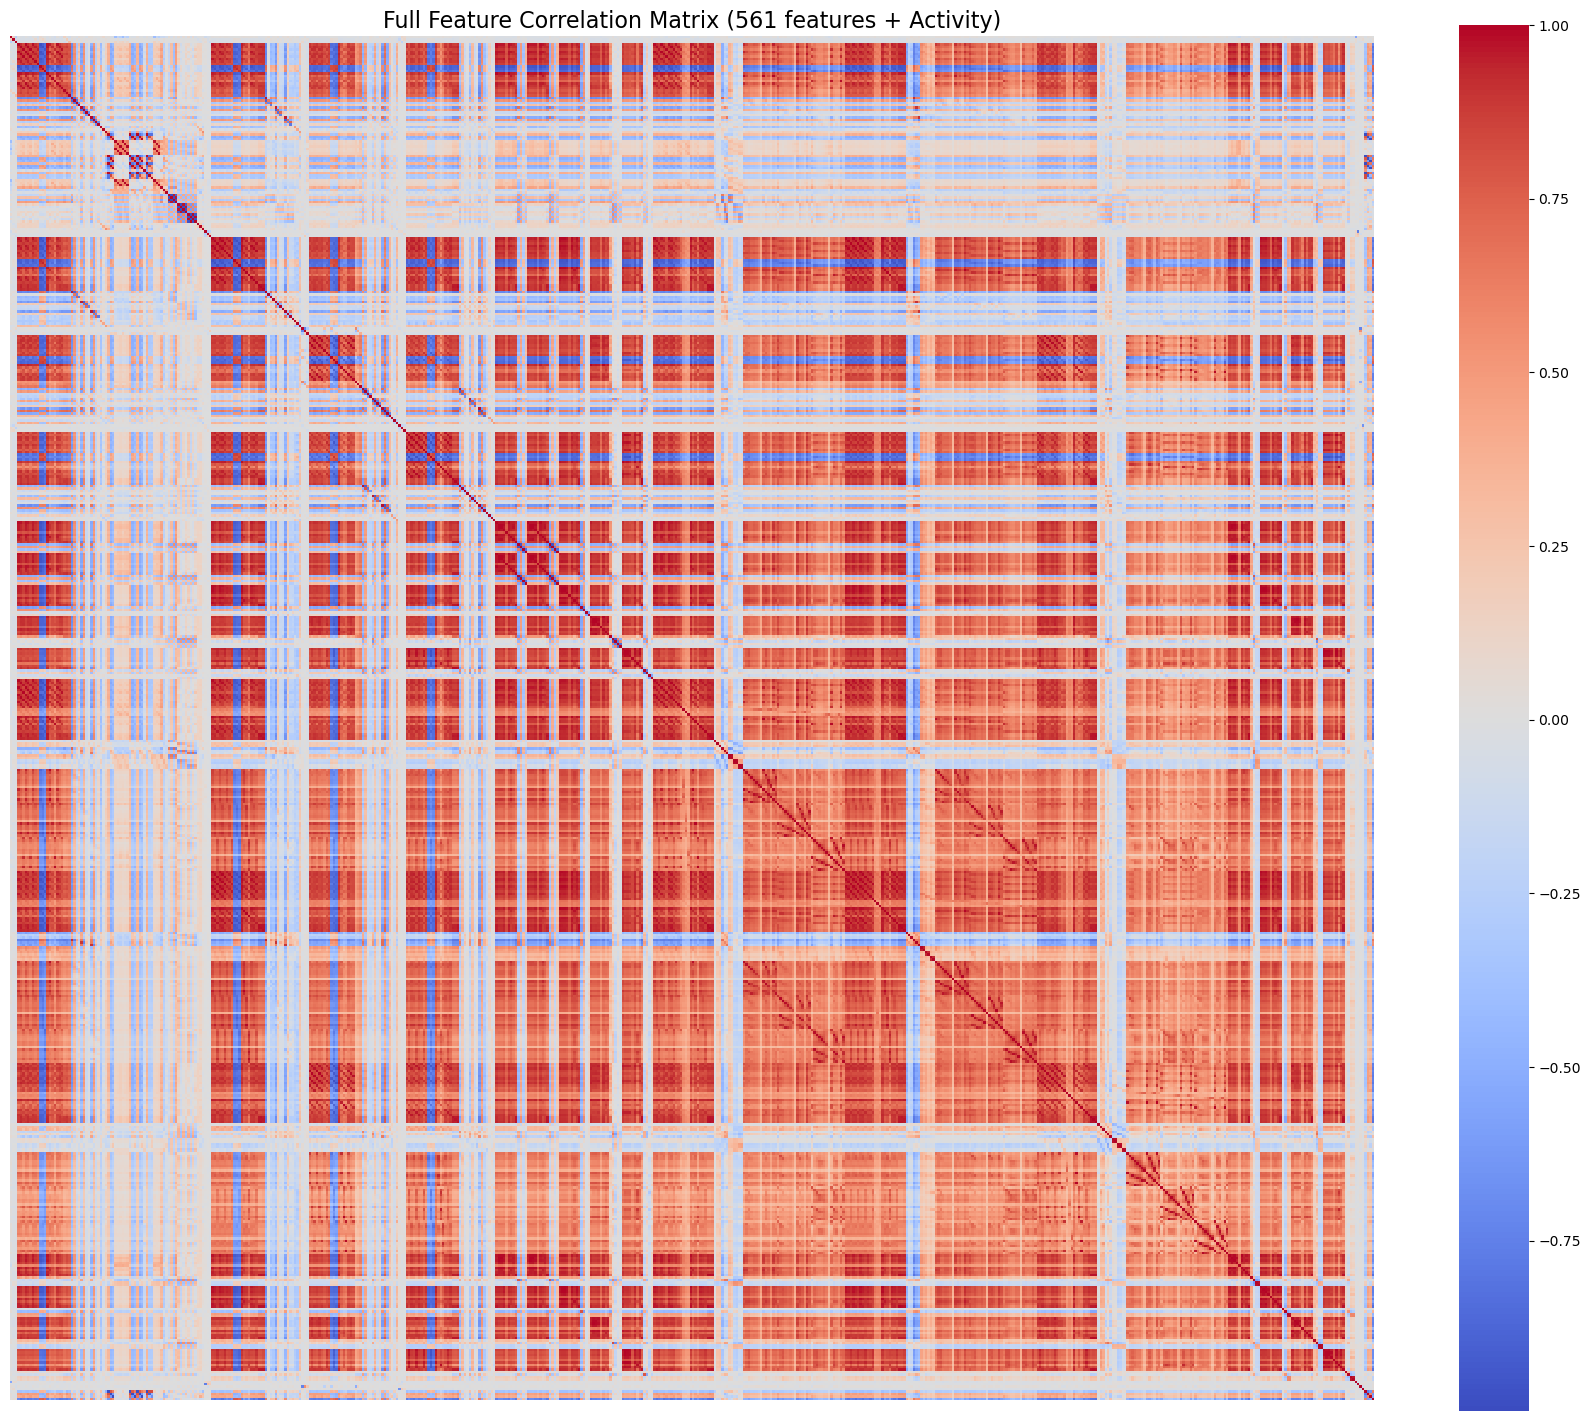

In [274]:
full_df = X_train_scaled.copy()
full_df["Activity"] = y_train.values
# Compute correlation matrix
corr_matrix = full_df.corr()
# Plot large heatmap
plt.figure(figsize=(22, 18))  
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar=True,
    xticklabels=False,  # Hide labels (too many)
    yticklabels=False
)
plt.title("Full Feature Correlation Matrix (561 features + Activity)", fontsize=16)
plt.savefig("plots/full_correlation_heatmap.png", dpi=200, bbox_inches='tight')
plt.show()

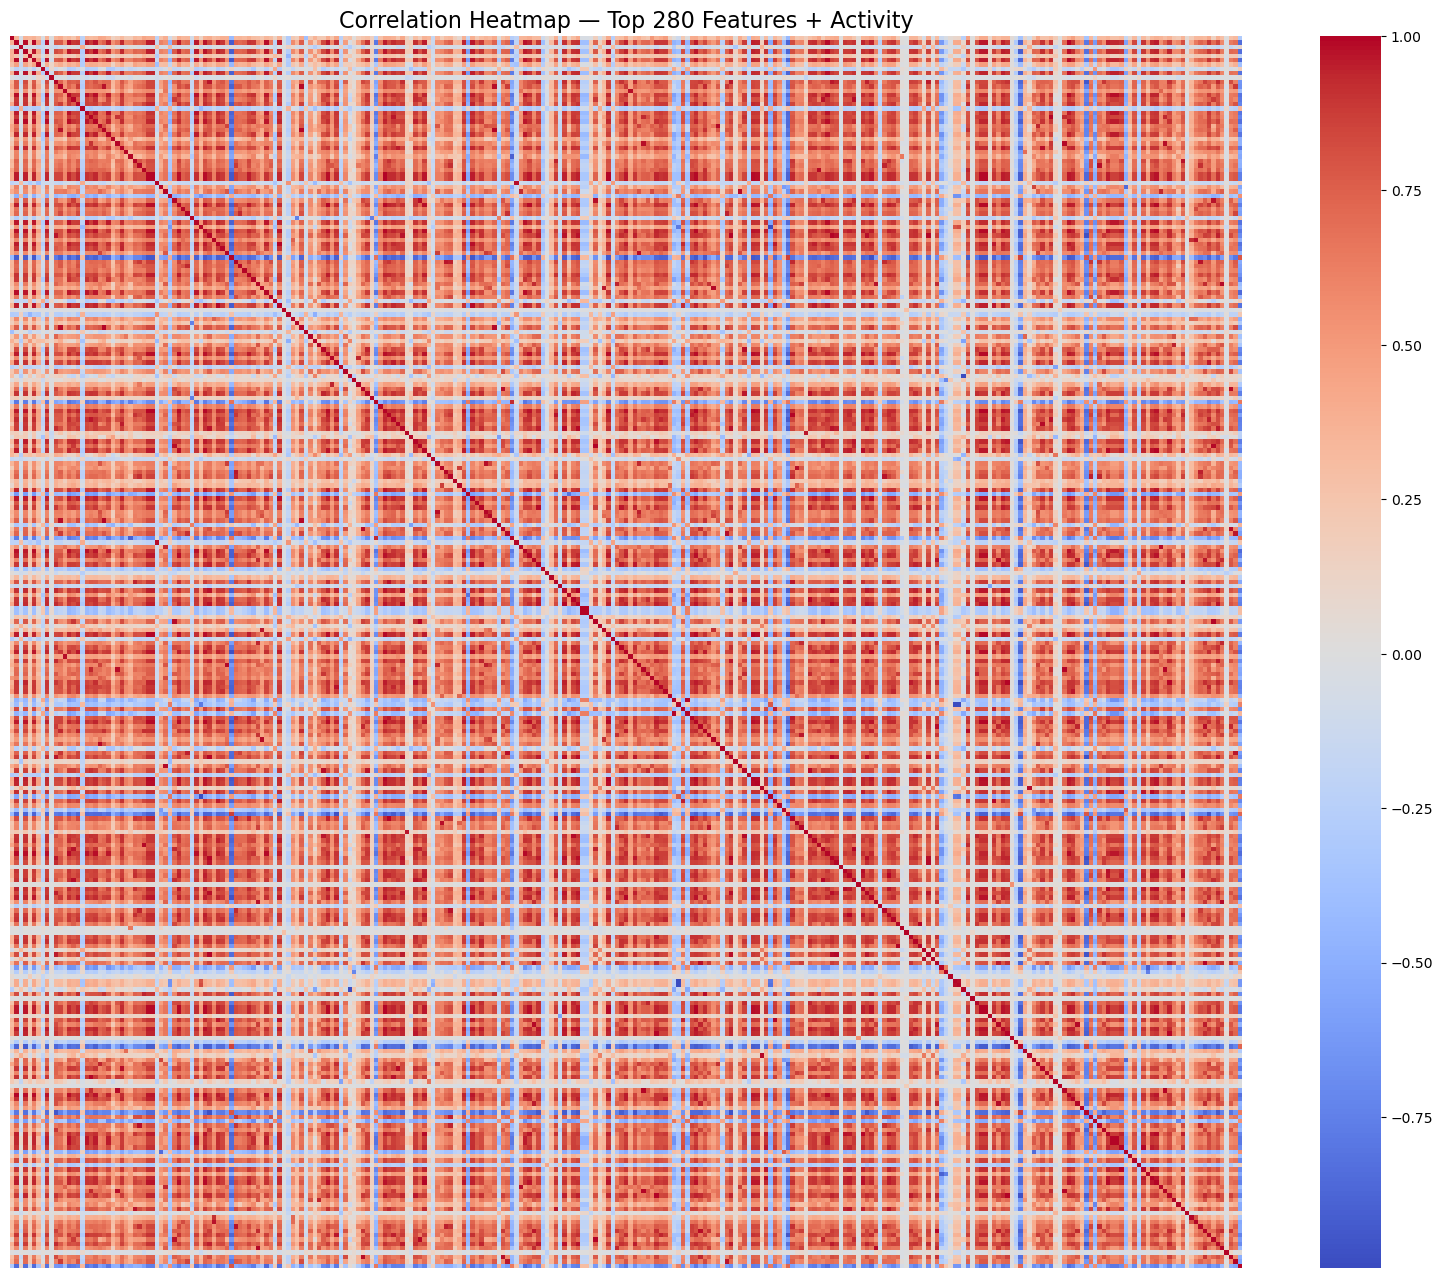

In [202]:
# Combine X and y
full_df = X_train_scaled.copy()
full_df["Activity"] = y_train.values
# Compute variance of each feature (exclude target)
variances = full_df.drop("Activity", axis=1).var().sort_values(ascending=False)
# Select top 280 features
top_features = variances.head(280).index.tolist()
# Add the target variable
top_features.append("Activity")
# Subset dataframe
df_280 = full_df[top_features]
# Compute correlation matrix
corr_matrix_280 = df_280.corr()
# Plot heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(
    corr_matrix_280,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar=True,
    xticklabels=False,
    yticklabels=False
)
plt.title("Correlation Heatmap — Top 280 Features + Activity", fontsize=16)
plt.savefig("plots/correlation_heatmap_280.png", dpi=200, bbox_inches='tight')
plt.show()

In [99]:
df_clusters.columns

Index(['fBodyAcc-sma()', 'fBodyAcc-meanFreq()-Z', 'tGravityAcc-energy()-X',
       'tGravityAcc-max()-Z', 'angle(X,gravityMean)',
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyGyro-meanFreq()-Y',
       'tBodyAcc-arCoeff()-Y,4', 'fBodyGyro-skewness()-Z',
       'tBodyGyroJerk-arCoeff()-Y,3', 'fBodyGyro-bandsEnergy()-49,64_2',
       'tBodyAcc-arCoeff()-Y,3', 'fBodyGyro-bandsEnergy()-57,64',
       'tBodyAcc-arCoeff()-Z,3', 'tBodyGyro-mean()-X', 'Cluster'],
      dtype='object')